# Introduction to LangGraph - Module 4: Building Our Assistant

# Pre-requisites

In [59]:
!pip install -qU langgraph langgraph_sdk langchain_openai langchain_core langgraph-prebuilt langchain_community langchain-tavily wikipedia

  Preparing metadata (setup.py) ... done


# Parallel Node Execution

We have gone through human-in-the-loop in depth in Module 3 and memory concepts in Module 2.

In this Module, we will dive into multi-agent workflows and build up a multi-agent research assistant that ties together all of the modules from previous modules.

## Fan out and Fan in

Fanning out and fanning in is something that we often want to do in graphs.

Let's start with a simple linear graph that overwrites the state at each step.

In [2]:
from google.colab import userdata
import os
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

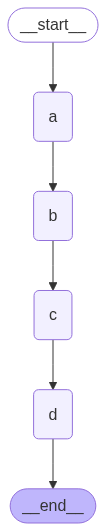

In [3]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: str


class ReturnNodeValue:
    def __init__(self, node_secret:str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {'state': [self._value]}


# Builder
builder = StateGraph(State)

# Nodes
# Initialize each node with `node_secret`
builder.add_node('a', ReturnNodeValue("I'm A"))
builder.add_node('b', ReturnNodeValue("I'm B"))
builder.add_node('c', ReturnNodeValue("I'm C"))
builder.add_node('d', ReturnNodeValue("I'm D"))

# Logic
builder.add_edge(START, 'a')
builder.add_edge('a', 'b')
builder.add_edge('b', 'c')
builder.add_edge('c', 'd')
builder.add_edge('d', END)

# Compile
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
graph.invoke({'state': []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm B"]
Adding I'm D to ["I'm C"]


{'state': ["I'm D"]}

If we run `b` and `c` nodes in parallel and then run `d`.

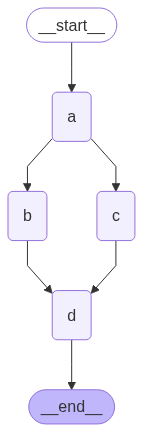

In [5]:
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Logic
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

This is acutally doing fan in and fan out in the sense that we are fanning out from `a`. We are running `a` as a step, running `b` and `c` together in the same step of the graph, and running `d` as a third step.

In [6]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
An error occurred: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


We received an error because both `b` and `c` nodes are writing to the same state key/channel in the same step.

This is an important concept when running nodes in parallel! When using fan out, we need to be sure that we are using a reducer if steps are writing to the same channel/key to aggregate those updates.

Assume here we will apply `operator.add` as our recuder function to perform list concatenation.

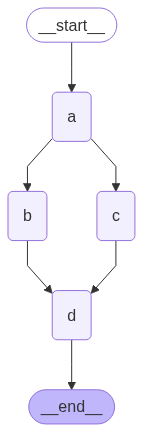

In [7]:
import operator
from typing import Annotated

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: Annotated[list, operator.add]


# Build
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Logic
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm D"]}

We now see that we append to state for the updates made in parallel by `b` and `c`.

## Waiting for nodes to finish

Consider a case where one parallel path has more steps than the other one:

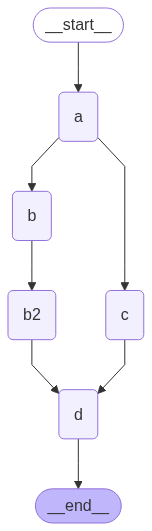

In [9]:
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Logic
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(
    ["b2", "c"], # parallel nodes to fan in
    "d"
)
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In this case, `b`, `b2`, and `c` are all part of the same step. The graph will wait for all of these to be completed before proceeding to step `d`.

In [10]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]}

## Setting the order of state updates

However, within each step we do not have specific control over the order of the state updates. It is a deterministic order determined by LangGraph based upon graph topology that *we do not control*.

In the above example, we see that `c` is added before `b2`. However, we can use a custom reducer to customize this sorted state updates.

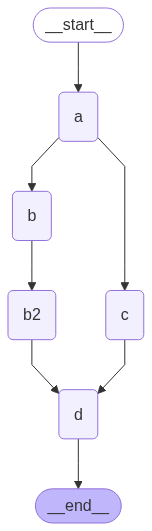

In [11]:
def sorting_reducer(left, right):
    """Combine and sort the values in a list"""
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]

    return sorted(left + right, reverse=False)


class State(TypedDict):
    # `sorting_reducer` will sort the values in state
    state: Annotated[list, sorting_reducer]


# Build
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Logic
builder.add_edge(START, "a")
builder.add_edge("a", "b")          # fan out
builder.add_edge("a", "c")          # fan out
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")  # fan in
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm B2", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm B2", "I'm C", "I'm D"]}

We see that the `sorting_reducer` sorts the updated state values.

The `sorting_reducer` reducer example sorts all values globally. We can also
1. write outputs to a separate field in the state during the parallel step
2. use a "sink" node after the parallel step to combine and order those outputs
3. clear the temporary field after combining

## Working with LLMs

In a realistic example, assume that we want to gather context from two external sources (Wikipedia and Web-Search) and have an LLM answer a question.

In [13]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [14]:
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]   # aggregate searched results

In [15]:
from google.colab import userdata
import os
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

In [28]:
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_community.document_loaders import WikipediaLoader
from langchain_tavily import TavilySearch


def search_web(state):
    """Retrieve docs from web search"""
    # Search
    tavily_search = TavilySearch(max_results=3)
    search_docs = tavily_search.run(state['question'])['results']
    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {'context': [formatted_search_docs]}


def search_wiki(state):
    """Retrieve docs from wikipedia"""
    # Search
    search_docs = WikipediaLoader(
        query=state['question'],
        load_max_docs=3
    ).load()

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {'context': [formatted_search_docs]}


def generate_answer(state):
    """Answer a question"""
    # Get state
    context = state['context']
    question = state['question']

    # Template
    answer_template = "Answer the question {question} using this context: {context}"
    answer_instructions = answer_template.format(
        question=question,
        context=context
    )

    # Answer
    answer = llm.invoke(
        [SystemMessage(content=answer_instructions)] + [HumanMessage(content=f"Answer the question.")]
    )

    # Append it to state
    return {'answer': answer}

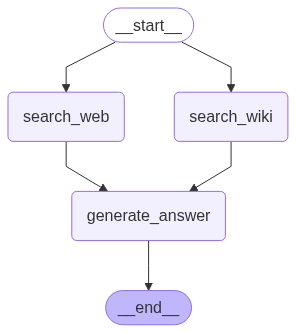

In [29]:
# Build
builder = StateGraph(State)

# Nodes
builder.add_node("search_web",search_web)
builder.add_node("search_wiki", search_wiki)
builder.add_node("generate_answer", generate_answer)

# Logic
builder.add_edge(START, "search_wiki")                # fan out
builder.add_edge(START, "search_web")                 # fan out
builder.add_edge("search_wiki", "generate_answer")    # fan in
builder.add_edge("search_web", "generate_answer")     # fan in
builder.add_edge("generate_answer", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
result = graph.invoke({"question": "Who won the NBA FMVP in 2022?"})
result['answer'].content

'Stephen Curry won the NBA Finals Most Valuable Player (FMVP) award in 2022.'

## LangGraph API

Assume our agent is hosted at http://127.0.0.1:2024

In [ ]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

In [ ]:
thread = await client.threads.create()
input_question = {"question": "Who won the NBA FMVP in 2022?"}
async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="parallelization",
    input=input_question,
    stream_mode="values"
):
    # Check if answer has been added to state
    if event.data is not None:
        answer = event.data.get('answer', None)
        if answer:
            print(answer['content'])

# Sub-graphs

**Sub-graphs** allow us to create and manage different states in different parts of our graph. This is particularly useful for multi-agent systems, with teams of agents that each have their own state.

In [2]:
from google.colab import userdata
import os
os.environ['LANGSMITH_API_KEY'] = userdata.get('LANGSMITH_API_KEY')
os.environ['LANGSMITH_TRACING_V2'] = userdata.get('LANGSMITH_TRACING_V2')
os.environ['LANGSMITH_PROJECT'] = userdata.get('LANGSMITH_PROJECT')

Consider a toy example that we have a system that accepts logs. This system performs two separate sub-tasks by different agents (summarize logs or find failure modes), and then we want to perform these two operations in two different sub-graphs.

Here we want to understand how the graphs communicate. This communication is done with **overlapping keys**:
- The sub-graphs can access `docs` from the parent
- The parent can access `summary` or `failture_report` from the sub-graphs.

We need to define a schema for the logs that will be input to our graph.

In [3]:
from operator import add
from typing_extensions import TypedDict
from typing import List, Optional, Annotated


# The structure of the logs
class Log(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]

## Sub-graph definition

First we will define our failure analysis sub-graph, which uses `FailureAnalysisState`:

In [4]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


# Failure Analysis Sub-graph States
class FailureAnalysisState(TypedDict):
    cleaned_logs: List[Log]
    failures: List[Log]
    fail_summary: str
    processed_logs: List[str]

class FailureAnalysisOutputState(TypedDict):
    fail_summary: str
    processed_logs: List[str]

In [5]:
def get_failtures(state):
    """Get logs that contain a failure"""
    cleaned_logs = state['cleaned_logs']
    failures = [log for log in cleaned_logs if 'grade' in log]

    return {'failures': failures}


def generate_summary(state):
    """Generate summary of failures"""
    failures = state['failures']
    # future LLM implementation: fail_summary = summarize(failtures)
    fail_summary = "Poor quality retrieval of Chroma documentation."

    return {
        'fail_summary': fail_summary,
        'processed_logs': [f"failture-analysis-on-log-{failure['id']}" for failure in failures]
    }

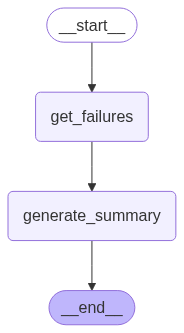

In [6]:
# Build
fail_builder = StateGraph(
    state_schema=FailureAnalysisState,
    output_schema=FailureAnalysisOutputState
)

# Nodes
fail_builder.add_node('get_failures', get_failtures)
fail_builder.add_node('generate_summary', generate_summary)

# Logic
fail_builder.add_edge(START, 'get_failures')
fail_builder.add_edge('get_failures', 'generate_summary')
fail_builder.add_edge('generate_summary', END)

# Compile
graph = fail_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

Next, we will define the question summarization sub-graph, which uses `QuestionSummarizationState`.

In [7]:
# Summarization subgraph states
class QuestionSummarizationState(TypedDict):
    cleaned_logs: List[Log]
    qs_summary: str
    report: str
    processed_logs: List[str]


class QuestionSummarizationOutputState(TypedDict):
    report: str
    processed_logs: List[str]

In [8]:
def generate_summary(state):
    cleaned_logs = state['cleaned_logs']
    # future LLM implementation: qs_summary = summarize(generate_summary)
    qs_summary = "Question focused on usage of Chroma vector store."

    return {
        'qs_summary': qs_summary,
        'processed_logs': [f"summary-on-log-{log['id']}" for log in cleaned_logs]
    }

def send_to_slack(state):
    qs_summary = state['qs_summary']
    # future LLM implementation: report = report_generation(qs_summary)
    report = "<dummy slack message>"

    return {'report': report}

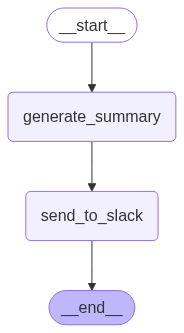

In [9]:
# Build
qs_builder = StateGraph(
    state_schema=QuestionSummarizationState,
    output_schema=QuestionSummarizationOutputState
)

# Nodes
qs_builder.add_node('generate_summary', generate_summary)
qs_builder.add_node('send_to_slack', send_to_slack)

# Logic
qs_builder.add_edge(START, 'generate_summary')
qs_builder.add_edge('generate_summary', 'send_to_slack')
qs_builder.add_edge('send_to_slack', END)

# Compile
graph = qs_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

## Adding sub-graphs to our parent graph

We will create our parent graph with `EntryGraphState`, and then add our sub-graphs as nodes.

```python
# Entry graph state
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: Annotated[List[Log], add]    # USED BY BOTH sub-graphs
    fail_summary: str                          # Generated in the failure sub-graph
    report: str                                # Generated in the qs sub-graph
    processed_logs: Annotated[List[int], add]  # Generated in BOTH sub-graphs
```

Why does `cleaned_logs` have a reducer if it only goes *into* each sub-graph as an input? It is not modified anyway:
```python
cleaned_logs: Annotated[List[Log], add]
```

This is because the output state of the subgraphs will contain **all keys**, even if they are unmodified.

The sub-graphs are running in parallel. Because the parallel sub-graphs return the same key, they need to have a reducer like `operator.add` to combine the incoming values from each sub-graph. However, we can work around this by using another concept.

We can simpy create an output state schema for each sub-graph and ensure that the output state schema contains different keys to publish as output. Hence, now we do not actually need each sub-graph to output `cleaned_logs`.

In [11]:
# Entry graph state
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: List[Log]
    fail_summary: str                          # Generated in the failure sub-graph
    report: str                                # Generated in the qs sub-graph
    processed_logs: Annotated[List[int], add]  # Generated in BOTH sub-graphs

In [12]:
def clean_logs(state):
    # Get logs
    raw_logs = state['raw_logs']
    # Data cleaning raw_logs -> docs
    cleaned_logs = raw_logs

    return {'cleaned_logs': cleaned_logs}

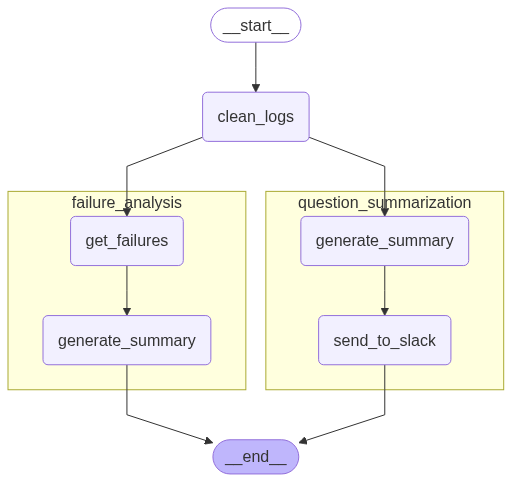

In [13]:
# Build
entry_builder = StateGraph(EntryGraphState)

# Nodes
entry_builder.add_node('clean_logs', clean_logs)
# Sub-graphs
entry_builder.add_node('failure_analysis', fail_builder.compile())
entry_builder.add_node('question_summarization', qs_builder.compile())

# Logic
entry_builder.add_edge(START, 'clean_logs')
entry_builder.add_edge('clean_logs', 'failure_analysis')          # fan out
entry_builder.add_edge('clean_logs', 'question_summarization')    # fan out
entry_builder.add_edge('failure_analysis', END)                   # fan in
entry_builder.add_edge('question_summarization', END)             # fan in

# Compile
graph = entry_builder.compile()

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

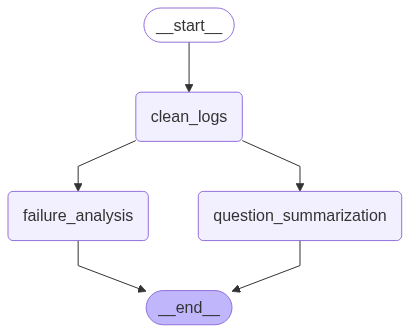

In [14]:
display(Image(graph.get_graph(xray=0).draw_mermaid_png()))

In [15]:
# Dummy logs
question_answer = Log(
    id="1",
    question="How can I import ChatOllama?",
    answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
)

question_answer_feedback = Log(
    id="2",
    question="How can I use Chroma vector store?",
    answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
    grade=0,
    grader="Document Relevance Recall",
    feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
)

raw_logs = [question_answer,question_answer_feedback]
graph.invoke({"raw_logs": raw_logs})

{'raw_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}],
 'cleaned_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, 

# Map-reduce

**Map-reduce** operations are essential for efficient task decomposition and parallel processing.

Map-reduce has two phases:
1. `Map`: breaking a task into smaller sub-tasks, processing each sub-task in parallel.
2. `Reduce`: aggregating the results across all of the completed, parallelized sub-tasks.

As an example, we will design a system that will
1. `Map`: creating a set of jokes about a topic.
2. `Reduce`: picking the best joke from the list.

We will use an LLM to do the job generation and selection.

In [16]:
from google.colab import userdata
import os
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['LANGSMITH_API_KEY'] = userdata.get('LANGSMITH_API_KEY')
os.environ['LANGSMITH_TRACING_V2'] = userdata.get('LANGSMITH_TRACING_V2')
os.environ['LANGSMITH_PROJECT'] = userdata.get('LANGSMITH_PROJECT')

In [17]:
from langchain_openai import ChatOpenAI

# Prompts we will use
subjects_prompt = "Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."
joke_prompt = "Generate a joke about {subject}"
best_joke_prompt = """
Below are a bunch of jokes about {topic}.
Select the best one! Return the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n  {jokes}
"""

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)

## State

First, we will define the entry point of the graph that will
- Take a user input topic
- Produce a list of joke topics from it
- Send each joke topic to our above joke generation node


Our state has a `jokes` key, which will accumulate jokes from parallelized joke generation.

In [18]:
import operator
from typing_extensions import TypedDict
from typing import Annotated
from pydantic import BaseModel


class Subjects(BaseModel):
    subjects: list[str]

class BestJoke(BaseModel):
    id: int

class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str

We need a node to generate subjects for jokes:

In [19]:
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state['topic'])
    response = model.with_structured_output(Subjects).invoke(prompt)

    return {'subjects': response.subjects}

The charming magic here is to use `Send` to create a joke for each subject.

This is very useful. `Send` can automatically parallelize joke generation for any number of subjects. In our case, `Send` will take two input parameters:
- `generate_joke`: Name of the node in the graph to generate joke
- `{'subject': s}`: State to send

We will see in the next section that the `generate_joke` requires a `state` argument, which only need `subject` key in that function.

Therefore, to summarize the use of `Send`, we know that a typical syntax of `Send`:
```python
[
    Send(
        <node-to-parallelize>,
        <keys-needed-to-parallelize>
    )
    for keys in state
]
```

`Send` allows us to pass any state that we want to `generate_joke`. It does not have to align with `OverallState`. In this case, `generate_joke` is using its own internal state, and we can populate this via `Send`.

In [20]:
from langgraph.types import Send

def continue_to_jokes(state: OverallState):
    return [
        Send('generate_joke', {'subject': s})
        for s in state['subjects']
    ]

## Joke generation (map)

Now we will define a node that will create our jokes, `generate_joke`. We will write them back to `jokes` in `OverallState`. This key has a reducer that will combine lists.

In [21]:
class Joke(BaseModel):
    joke: str

class JokeState(TypedDict):
    subject: str

In [33]:
def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state['subject'])
    response = model.with_structured_output(Joke).invoke(prompt)

    return {'jokes': [response.joke]} # need to take out the joke key and update as a LIST

## Best joke selection (reduce)

Now we will add logic to pick the best joke:

In [34]:
def best_joke(state: OverallState):
    jokes = "\n\n".join(state['jokes'])
    prompt = best_joke_prompt.format(
        topic=state['topic'],
        jokes=jokes
    )
    response = model.with_structured_output(BestJoke).invoke(prompt)

    return {'best_selected_joke': state['jokes'][response.id]}

## Compile

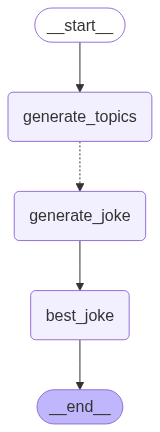

In [35]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Build
builder = StateGraph(OverallState)

# Nodes
builder.add_node('generate_topics', generate_topics)
builder.add_node('generate_joke', generate_joke)
builder.add_node('best_joke', best_joke)

# Logic
builder.add_edge(START, 'generate_topics')
builder.add_conditional_edges(
    'generate_topics',
    continue_to_jokes,     # How we used `Send`
    ['generate_joke']
)
builder.add_edge('generate_joke', 'best_joke')
builder.add_edge('best_joke', END)

# Compile
graph = builder.compile()

Image(graph.get_graph().draw_mermaid_png())

The dotted-line represents a conditional edge. The `contiue_to_jokes` uses `Send` so that it will spawn some number of `geenrate_joke` nodes based on the length of the topics we want.

In [36]:
# Call the graph: here we call it to generate a list of jokes
for s in graph.stream({"topic": "animals"}):
    print(s)

{'generate_topics': {'subjects': ['Animal Behavior and Communication', 'Conservation and Endangered Species', 'Animal Habitats and Ecosystems']}}
{'generate_joke': {'jokes': ['Why did the squirrel bring a suitcase to the forest?\n\nBecause it heard the ecosystem was "tree-mendous" and wanted to branch out!']}}
{'generate_joke': {'jokes': ['Why did the endangered species start a band?\n\nBecause they wanted to make some noise before they went extinct!']}}
{'generate_joke': {'jokes': ['Why did the parrot bring a ladder to the comedy club?\n\nBecause it wanted to reach the "punchline" in its jokes!']}}
{'best_joke': {'best_selected_joke': 'Why did the parrot bring a ladder to the comedy club?\n\nBecause it wanted to reach the "punchline" in its jokes!'}}


# Research Assistant

Research automation requries customization: raw LLM outputs are often poorly suited for real-world decision-making workflows.

In this section, we will build a lightweight, multi-agent system around chat models that customizes the research process.
- **Source Selection**
  - Users can choose any set of input sources for their research.
- **Planning**
  - Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
  - Human-in-the-loop will be used to refine these sub-topics before research begins.
- **LLM Utilization**
  - Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
  - The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://arxiv.org/abs/2402.14207) paper.
  - These interviews will be captured using sub-graphs with their internal state.
- **Research Process**
  - Experts will gather information to answer analyst question in parallel.
  - All interviews will be conducted simultaneously through map-reduce.
- **Output Format**
  - The gathered insights from each interview will be synthesized into a final report.
  - We will use costomizable prompts for the report, allowing for a flexible output format.

In [3]:
from google.colab import userdata
import os
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['LANGSMITH_API_KEY'] = userdata.get('LANGSMITH_API_KEY')
os.environ['LANGSMITH_TRACING_V2'] = userdata.get('LANGSMITH_TRACING_V2')
os.environ['LANGSMITH_PROJECT'] = userdata.get('LANGSMITH_PROJECT')

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0)

## Generate Analysts: Human-in-the-loop

Create analysts and review them using human-in-the-loop

In [36]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field


class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst."
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic."
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nROle: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"


class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations."
    )


class GenerateAnalystsState(TypedDict):
    topic: str                      # Research topic
    max_analysts: int               # Number of analysts
    human_analyst_feedback: str     # Human feedback
    analysts: List[Analyst]         # Analyst asking questions

In [37]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}

2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:

{human_analyst_feedback}

3. Determine the most interesting themes based upon documents and / or feedback above.

4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""


def create_analysts(state: GenerateAnalystsState):
    """Create AI analysts"""
    topic = state['topic']
    max_analysts = state['max_analysts']
    human_analyst_feedback = state.get('human_analyst_feedback')

    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback,
        max_analysts=max_analysts
    )

    # Generate questions
    response = structured_llm.invoke(
        [SystemMessage(content=system_message)] + [HumanMessage(content="Generate the set of analysts.")]
    )

    return {'analysts': response.analysts} # follows the `Perspectives` structured output


def human_feedback(state: GenerateAnalystsState):
    """No-operation node that should be interrupted on"""
    pass


def should_continue(state: GenerateAnalystsState):
    """Return the next node to execute"""
    # Check if human feedback
    human_analyst_feedback = state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return 'create_analysts'
    # otherwise end
    return END

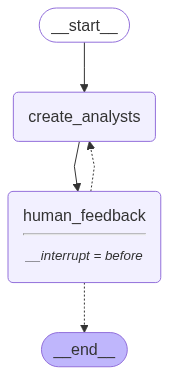

In [38]:
# Build
builder = StateGraph(GenerateAnalystsState)

# Nodes
builder.add_node('create_analysts', create_analysts)
builder.add_node('human_feedback', human_feedback)

# Logic
builder.add_edge(START, 'create_analysts')
builder.add_edge('create_analysts', 'human_feedback')
builder.add_conditional_edges(
    'human_feedback',
    should_continue,
    ['create_analysts', END]
)

# Compile
memory = MemorySaver()
graph = builder.compile(
    checkpointer=memory,
    interrupt_before=['human_feedback']
)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [39]:
# Input
max_analysts = 3
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}
initial_state = {"topic": topic, "max_analysts": max_analysts}

# Run the graph until the first interruption
for event in graph.stream(
    initial_state,
    thread,
    stream_mode="values"
):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Carter focuses on the technological advancements and integration of new frameworks like LangGraph. Her primary concern is how adopting such frameworks can streamline processes, enhance efficiency, and drive innovation within organizations. She is motivated by the potential of LangGraph to transform traditional agent frameworks and improve computational capabilities.
--------------------------------------------------
Name: Mr. Raj Patel
Affiliation: GreenTech Solutions
Role: Sustainability Analyst
Description: Mr. Patel examines the environmental impact and sustainability benefits of adopting LangGraph. His focus is on how this framework can reduce energy consumption and improve resource efficiency in computational processes. He is driven by the need to align technological advancements with sustainable practices and reduce the carbon footprint of tech operations.
--------------

In [40]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [41]:
# Update the state as if we are in the `human_feedback` node
feedback_state = {"human_analyst_feedback": "Add in someone from a startup to add an entrepreneur perspective"}

graph.update_state(
    thread,
    feedback_state,
    as_node='human_feedback'
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f07e073-5f4b-62e7-8002-93c36569f2de'}}

In [42]:
# Continue the graph execution
for event in graph.stream(
    None,
    thread,
    stream_mode='values'
):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Carter focuses on the technological advancements and integration of new frameworks like LangGraph. Her primary concern is how adopting such frameworks can streamline processes, enhance efficiency, and drive innovation within organizations. She is motivated by the potential of LangGraph to transform traditional agent frameworks and improve computational capabilities.
--------------------------------------------------
Name: Mr. Raj Patel
Affiliation: GreenTech Solutions
Role: Sustainability Analyst
Description: Mr. Patel examines the environmental impact and sustainability benefits of adopting LangGraph. His focus is on how this framework can reduce energy consumption and improve resource efficiency in computational processes. He is driven by the need to align technological advancements with sustainable practices and reduce the carbon footprint of tech operations.
--------------

We can see that now we have 6 analysts. This is because the latter 3 are appended in the second round when we pass our feedback to the state.

In [43]:
# If we are satisfied withe new updated results, we simply supply no feedback
further_feedback_state = {"human_analyst_feedback": None}

graph.update_state(
    thread,
    further_feedback_state,
    as_node='human_feedback'
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f07e073-b482-64ab-8004-81a53fc1b770'}}

In [44]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [45]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [46]:
final_state.next

()

We see that the graph reaches the end.

We can now print out our final analysts:

In [47]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50)

Name: Alex Johnson
Affiliation: Tech Innovators Inc.
Role: Startup Entrepreneur
Description: Alex is a co-founder of a tech startup that focuses on developing innovative software solutions. With a keen interest in leveraging cutting-edge technologies, Alex is exploring LangGraph as a potential framework to enhance the startup's product offerings. Alex is particularly interested in how LangGraph can accelerate development cycles, reduce costs, and provide a competitive edge in the market.
--------------------------------------------------
Name: Dr. Emily Chen
Affiliation: Global Tech Solutions
Role: Senior Software Architect
Description: Dr. Chen is a seasoned software architect with extensive experience in designing and implementing large-scale systems. Her focus is on the technical benefits of adopting LangGraph, such as its scalability, flexibility, and integration capabilities. Dr. Chen is interested in how LangGraph can streamline complex workflows and improve system performance.
-

The final analysts are only 3 analysts instead of 6 because our initial `max_analysts = 3` is set. We indeed have an analyst `Alex Johnson` that comes from a startup.

## Conduct Interview

### Generate Question

In this section, the analyst will ask questions to the expert.

The interview is going between each analyst we just created and an expert. The expert here is effectively a system that has access to some sources that we give it to answer questions.

In [48]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState


class SearchQuery(BaseModel):
    search_query: str = Field(
        None,
        description="Search query for retrieval."
    )


class InterviewState(MessagesState):
    max_num_turns: int                       # Number of turns of conversation
    context: Annotated[list, operator.add]   # Source docs
    analyst: Analyst                         # Analyst asking questions
    interview: str                           # Interview transcript
    sections: list                           # Final key we duplicate in outer state for `Send`

In [49]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic.

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.

2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}

Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.

When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""


def generate_question(state: InterviewState):
    """Node to generate a question"""
    # Get state
    analyst = state['analyst']
    messages = state['messages']

    # Generate question
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke(
        [SystemMessage(content=system_message)] + messages
    )

    # Write messages to state
    return {'messages': question}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use
- specific websites, e.g., via `WebBaseLoader`
- indexed documents, .e.g, via RAG
- web search
- wikipedia search.

In [50]:
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

In [51]:
# Web search tool
from langchain_tavily import TavilySearch
tavily_search = TavilySearch(max_results=3)

In [52]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Now we need to create nodes to search the web and wikipedia. We will also create a node to answer analyst questions.

Finally, we will create nodes to save the full interview and to write a summry ("section") of the interview.

In [53]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = """You will be given a conversation between an analyst and an expert.

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.

First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query"""


def search_web(state: InterviewState):
    """Retrieve docs from web search"""
    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    response = structured_llm.invoke(
        [SystemMessage(content=search_instructions)] + state['messages']
    )

    # Search
    search_docs = tavily_search.run(response.search_query)['results']

    # Format
    formatted_search_docs = '\n\n---\n\n'.join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {'context': [formatted_search_docs]}



def search_wiki(state: InterviewState):
    """Retrieve docs from wikipedia"""
    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    response = structured_llm.invoke(
        [SystemMessage(content=search_instructions)] + state['messages']
    )

    # Search
    search_docs = WikipediaLoader(
        query=response.search_query,
        load_max_docs=2
    ).load()

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [54]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}.

You goal is to answer a question posed by the interviewer.

To answer question, use this context:

{context}

When answering questions, follow these guidelines:

1. Use only the information provided in the context.

2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1].

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc

6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list:

[1] assistant/docs/llama3_1.pdf, page 7

And skip the addition of the brackets as well as the Document source preamble in your citation."""


def generate_answer(state: InterviewState):
    """Answer a question"""
    # Get state
    analyst = state['analyst']
    messages = state['messages']
    context = state['context']

    # Answer question
    system_message = answer_instructions.format(
        goals=analyst.persona,
        context=context
    )
    response = llm.invoke(
        [SystemMessage(content=system_message)] + messages
    )

    # Name the message as coming from the expert
    response.name = 'expert'

    # Append it to state
    return {'messages': response}


def save_interview(state: InterviewState):
    """Save interviews"""
    # Get messages
    messages = state['messages']

    # Convert interview to a string
    interview = get_buffer_string(messages)

    # Save to interview key
    return {'interview': interview}


def route_messages(state: InterviewState, name: str = 'expert'):
    """Route between question and answer"""
    # Get messages
    messages = state['messages']
    max_num_turns = state.get('max_num_turns', 2)

    # Check the number of expert answers
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than `max_num_turns`
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question-answer pair.
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    # otherwise, continue to generate question
    return 'generate_question'

In [55]:
section_writer_instructions = """You are an expert technical writer.

Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents:
- The name of each source document is at the start of the document, with the <Document tag.

2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst:
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents

6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/

8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""


def write_section(state: InterviewState):
    """Answer a question"""
    # Get state
    interview = state['interview']
    context = state['context']
    analyst = state['analyst']

    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke(
        [SystemMessage(content=system_message)] + [HumanMessage(content=f"Use this source to write your section: {context}")]
    )

    # Append it to state
    return {'sections': [section.content]}

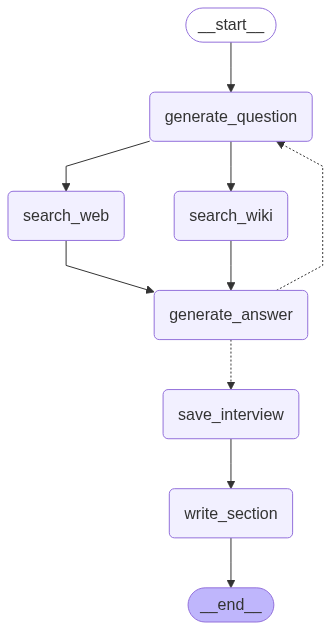

In [56]:
# Build
interview_builder = StateGraph(InterviewState)

# Nodes
interview_builder.add_node('generate_question', generate_question)
interview_builder.add_node('search_web', search_web)
interview_builder.add_node('search_wiki', search_wiki)
interview_builder.add_node('generate_answer', generate_answer)
interview_builder.add_node('save_interview', save_interview)
interview_builder.add_node('write_section', write_section)

# Logic
interview_builder.add_edge(START, 'generate_question')
interview_builder.add_edge('generate_question', 'search_web')
interview_builder.add_edge('generate_question', 'search_wiki')
interview_builder.add_edge('search_web', 'generate_answer')
interview_builder.add_edge('search_wiki', 'generate_answer')
interview_builder.add_conditional_edges(
    'generate_answer',
    route_messages,
    ['generate_question', 'save_interview']
)
interview_builder.add_edge('save_interview', 'write_section')
interview_builder.add_edge('write_section', END)

# Compile
memory = MemorySaver()
interview_graph = interview_builder.compile(
    checkpointer=memory,
).with_config(run_name="Conduct Interviews")

display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [57]:
# Pick one analyst
analysts[0]

Analyst(affiliation='Tech Innovators Inc.', name='Alex Johnson', role='Startup Entrepreneur', description="Alex is a co-founder of a tech startup that focuses on developing innovative software solutions. With a keen interest in leveraging cutting-edge technologies, Alex is exploring LangGraph as a potential framework to enhance the startup's product offerings. Alex is particularly interested in how LangGraph can accelerate development cycles, reduce costs, and provide a competitive edge in the market.")

We can now run the interview for this analyst:

In [60]:
from IPython.display import Markdown

topic = "The benefits of adopting LangGraph as an agent framework"
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}

interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## Unlocking Competitive Advantage with LangGraph: A Game-Changer for Tech Startups

### Summary

In the fast-paced world of tech startups, leveraging cutting-edge technologies is crucial for gaining a competitive edge. For Alex, a co-founder of a tech startup focused on innovative software solutions, exploring LangGraph presents an exciting opportunity to enhance product offerings. LangGraph is a framework that stands out for its ability to accelerate development cycles, reduce costs, and provide a competitive advantage in the market.

LangGraph is best understood as an orchestration framework with both declarative and imperative APIs, designed to manage complex AI workflows. It offers a reliable orchestration layer that provides developers with explicit control over the context reaching their Large Language Models (LLMs), while seamlessly handling production concerns like persistence, fault tolerance, and human-in-the-loop interactions [1]. This makes it particularly appealing for startups looking to build robust, production-ready AI systems.

One of the novel aspects of LangGraph is its graphical approach to constructing agent behaviors, which allows for the incorporation of conditional branches and loops. This is essential for developing agents that need to backtrack or manage complex multi-step tasks, offering a level of flexibility that traditional linear coding frameworks lack [2]. This capability is crucial for startups aiming to develop sophisticated, adaptable, and industry-specific AI applications.

LangGraph also excels in creating stateful and multi-actor applications with LLMs, thanks to its cyclic data flows and high-level abstraction. This enables applications to remember past interactions and use that information to improve or customize future outputs, which is particularly useful for developing advanced chatbots and other AI-driven user experiences [3]. The platform's integrated developer studio and opinionated API further streamline the process of deploying and scaling applications, making it an attractive option for startups looking to iterate quickly and scale effortlessly [4].

In summary, LangGraph offers a comprehensive solution for tech startups like Alex's, providing the tools needed to build and scale AI workloads efficiently. Its unique features and capabilities make it a valuable asset for startups seeking to innovate and maintain a competitive edge in the rapidly evolving tech landscape.

### Sources
[1] https://blog.langchain.com/how-to-think-about-agent-frameworks/  
[2] https://community.latenode.com/t/what-are-the-main-advantages-of-choosing-langgraph-for-ai-agent-development/31000  
[3] https://www.ampcome.com/articles/what-is-langgraph-how-it-is-useful-in-building-llm-based-applications  
[4] https://www.langchain.com/langgraph  

### Parallelize Interviews: Map-Reduce

We can parallelize the interviews via `Send`, a map step. and then we combine them into the report body in a reduce step.

We will add a final step to write an intro and conclusion to the final report.

In [61]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

# Overall-Graph-State
class ResearchGraphState(TypedDict):
    topic: str                                 # Research topic
    max_analysts: int                          # Number of analysts
    human_analyst_feedback: str                # Human feedback
    analysts: List[Analyst]                    # Analyst asking questions
    sections: Annotated[list, operator.add]    # Send method
    introduction: str                          # Introduction of the final report
    content: str                               # Content of the final report
    conclusion: str                            # Conclusion of the final report
    final_report: str                          # Final report

In [62]:
from langgraph.types import Send

def initiate_all_interviews(state: ResearchGraphState):
    """This is the `map` step where we run each interview sub-graph using Send"""
    # Check if human feedback
    human_analyst_feedback = state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return 'create_analysts'

    # Otherwise kick off interviews in parallel
    else:
        topic = state['topic']
        return [
            Send(
                'conduct_interview',
                {
                    'analyst': analyst,
                    'messages': [HumanMessage(content=f"So you said you were writing an article on {topic}?")]
                }
            )
            for analyst in state['analysts']
        ]

In [63]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic:

{topic}

You have a team of analysts. Each analyst has done two things:

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task:

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos.
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:

1. Use markdown formatting.
2. Include no pre-amble for the report.
3. Use no sub-heading.
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from:

{context}"""


def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state['sections']
    topic = state['topic']

    # Concatenate all sections together
    formatted_str_sections = '\n\n'.join(
        [f"{section}" for section in sections]
    )

    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(
        topic=topic,
        context=formatted_str_sections
    )

    report = llm.invoke(
        [SystemMessage(content=system_message)] + [HumanMessage(content="Write a report based upon these memos.")]
    )

    return {'content': report.content}

In [64]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting.

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header.

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""


def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")])
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")])
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

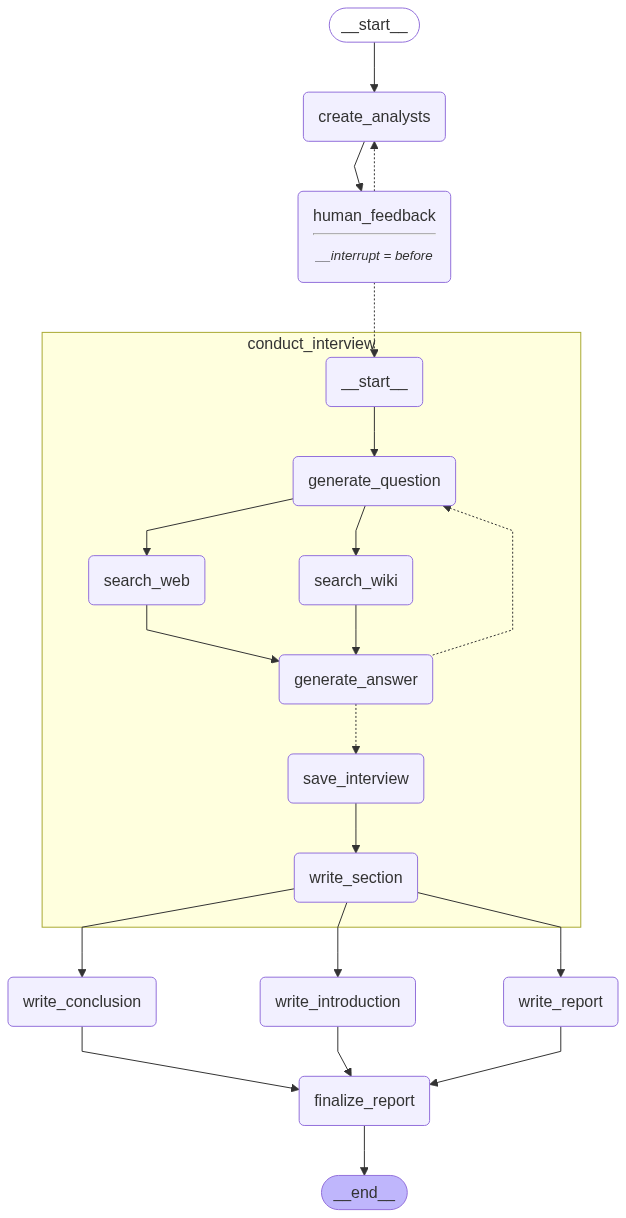

In [66]:
# Build
builder = StateGraph(ResearchGraphState)

# Nodes
builder.add_node('create_analysts', create_analysts)
builder.add_node('human_feedback', human_feedback)
builder.add_node('conduct_interview', interview_builder.compile()) # subgraphs
builder.add_node('write_report', write_report)
builder.add_node('write_introduction', write_introduction)
builder.add_node('write_conclusion', write_conclusion)
builder.add_node('finalize_report', finalize_report)

# Logic
builder.add_edge(START, 'create_analysts')
builder.add_edge('create_analysts', 'human_feedback')
builder.add_conditional_edges(
    'human_feedback',
    initiate_all_interviews,  # parallelization using `Send`
    ['create_analysts', 'conduct_interview']
)
builder.add_edge('conduct_interview', 'write_introduction')      # fan out
builder.add_edge('conduct_interview', 'write_conclusion')        # fan out
builder.add_edge('conduct_interview', 'write_report')            # fan out
builder.add_edge(
    ['write_introduction', 'write_conclusion', 'write_report'],  # fan in
    'finalize_report'
)
builder.add_edge('finalize_report', END)

# Compile
memory = MemorySaver()
graph = builder.compile(
    checkpointer=memory,
    interrupt_before=['human_feedback']
)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Now we can ask an open-ended question. We know the graph will stop at `human_feedback` node for us to confirm:

In [67]:
# Inputs
max_analysts = 3
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}
initial_state = {"topic": topic, "max_analysts": max_analysts}

# Run the graph until the first interruption
for event in graph.stream(
    initial_state,
    thread,
    stream_mode="values"
):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Carter focuses on the technological advancements and integration of new frameworks like LangGraph. She is particularly interested in how LangGraph can streamline processes, improve efficiency, and enhance the capabilities of AI agents. Her motive is to identify cutting-edge technologies that can provide a competitive edge to organizations.
--------------------------------------------------
Name: Mr. Raj Patel
Affiliation: Green Future Analytics
Role: Sustainability Analyst
Description: Mr. Patel examines the environmental impact and sustainability benefits of adopting new technologies. He is interested in how LangGraph can contribute to reducing energy consumption and promoting sustainable practices in AI development. His focus is on ensuring that technological advancements align with environmental goals.
--------------------------------------------------
Name: Ms. Linda Zhang

In [68]:
# We now update the state as if we are the human_feedback node
feedback_state = {"human_analyst_feedback": "Add in the CEO of gen ai native startup"}
graph.update_state(
    thread,
    feedback_state,
    as_node="human_feedback"
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f07e0ae-6b43-696f-8002-2815f35b3aff'}}

In [69]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Carter focuses on the technological advancements and integration of new frameworks like LangGraph. She is particularly interested in how LangGraph can streamline processes, improve efficiency, and enhance the capabilities of AI agents. Her motive is to identify cutting-edge technologies that can provide a competitive edge to organizations.
--------------------------------------------------
Name: Mr. Raj Patel
Affiliation: Green Future Analytics
Role: Sustainability Analyst
Description: Mr. Patel examines the environmental impact and sustainability benefits of adopting new technologies. He is interested in how LangGraph can contribute to reducing energy consumption and promoting sustainable practices in AI development. His focus is on ensuring that technological advancements align with environmental goals.
--------------------------------------------------
Name: Ms. Linda Zhang

In [70]:
# Confirm we are happy
further_feedback_state = {"human_analyst_feedback": None}
graph.update_state(
    thread,
    further_feedback_state,
    as_node="human_feedback"
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f07e0af-ca6c-6cca-8004-1959c689b4a3'}}

In [ ]:
# Continue
for event in graph.stream(
    None,
    thread,
    stream_mode="updates"
):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [ ]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)